In [2]:
import os
import re
import sys
import copy
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.utils import shuffle
import gensim
from gensim.models import Word2Vec,Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [3]:
np.random.seed(42)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch import autograd
from torch.autograd import Variable

In [5]:
data_path = '../Datasets/IMDB/'

In [6]:
train_corpus = [] 
train_labels = np.zeros(25000)
train_labels[0:12500] = 1

In [7]:
with open(data_path+'train_pos.txt','r',encoding='latin1') as f:
    for line in f.readlines():
        train_corpus.append(line[:-1])
        
with open(data_path+'train_neg.txt','r',encoding='latin1') as f:
    for line in f.readlines():
        train_corpus.append(line[:-1])

In [8]:
test_corpus = []
test_labels = np.zeros(25000)
test_labels[0:12500] = 1

In [9]:
with open(data_path+'test_pos.txt','r',encoding='latin1') as f:
    for line in f.readlines():
        test_corpus.append(line[:-1])
        
with open(data_path+'test_neg.txt','r',encoding='latin1') as f:
    for line in f.readlines():
        test_corpus.append(line[:-1])

In [10]:
train_corpus,train_labels = shuffle(train_corpus,train_labels)
test_corpus,test_labels = shuffle(test_corpus,test_labels)

In [11]:
trainlength = len(train_corpus)
testlength = len(test_corpus)

In [12]:
def tag_sentence(sentence,label):
    return TaggedDocument(sentence,label)

In [13]:
def create_tags(Xtrain,ytrain,Xtest,ytest):
    tagged_train = []
    tagged_test= []
    for i in range(trainlength):
        if(ytrain[i]==1):
            tag = ['train_pos_'+str(i)]
        else:
            tag = ['train_neg_'+str(i)]
        tagged_train.append(tag_sentence(Xtrain[i].split(),tag))
    
    
    for i in range(testlength):
        if(ytest[i]==1):
            tag = ['test_pos_'+str(i)]
        else:
            tag = ['test_neg_'+str(i)]
        tagged_test.append(tag_sentence(Xtest[i].split(),tag))
    
    return tagged_train,tagged_test

In [14]:
train_tagged,test_tagged = create_tags(train_corpus,train_labels,test_corpus,test_labels)

In [15]:
d2vmodel = Doc2Vec(min_count=1,sample=1e-4, negative=5, workers=7,vector_size=100,
                   window=5,dm=0)

In [16]:
d2vmodel.build_vocab(train_tagged)

In [17]:
d2vmodel.train(train_tagged,total_examples=d2vmodel.corpus_count,epochs=20)

In [18]:
def generate_vectors(model,traindata,testdata,train_l,test_l):
    train_vectors = np.zeros((train_l,100))
    test_vectors = np.zeros((test_l,100))
    
    train_labels = torch.zeros(train_l).long()
    test_labels = torch.zeros(test_l).long()
    
    for i in range(train_l):
        tag = traindata[i].tags[0]
        _,label,_ = tag.split("_")
        train_vectors[i] = model.docvecs[tag]
        if(label=='pos'):
            train_labels[i] = 1
            
    for i in range(test_l):
        tag = testdata[i].tags[0]
        _,label,_ = tag.split("_")
        test_vectors[i] = model.infer_vector(testdata[i].words)
        if(label=='pos'):
            test_labels[i] = 1
            
    return train_vectors,train_labels,test_vectors,test_labels

In [19]:
trainv,trainl,testv,testl = generate_vectors(d2vmodel,train_tagged,test_tagged,trainlength,testlength)

In [20]:
trainvectors = torch.from_numpy(trainv).float()
testvectors = torch.from_numpy(testv).float()

In [21]:
batchsize = 50

In [22]:
traindataset = torch.utils.data.TensorDataset(trainvectors,trainl)
trainloader = torch.utils.data.DataLoader(traindataset,batch_size=batchsize)

In [23]:
testdataset = torch.utils.data.TensorDataset(testvectors,testl)
testloader = torch.utils.data.DataLoader(testdataset,batch_size=batchsize)

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
in_features = 100
layer1 = 64
layer2 = 32
out_features = 2

In [62]:
class network1(nn.Module):
    def __init__(self):
        super(network1,self).__init__()
        self.fc1 = nn.Linear(in_features,layer1)
        self.fc2 = nn.Linear(layer1,layer2)
        self.fc3 = nn.Linear(layer2,out_features)
        self.drop = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self,x):
        out = self.drop(self.relu(self.fc1(x)))
        out = self.drop(self.relu(self.fc2(out)))
        out =  F.log_softmax(self.fc3(out),dim=1)
        
        return out

In [63]:
model1 = network1()

In [64]:
model1 = model1.to(device)

In [65]:
optimizer = optim.Adam(model1.parameters())

In [66]:
numepochs = 25

In [67]:
def evaluate_accuracy(net,loader):
    net.eval()
    acc = 0
    total = 0
    with torch.no_grad():
        for i,(Xtrain,ytrain) in enumerate(loader):
            Xtrain = Xtrain.to(device)
            ytrain = ytrain.to(device)
            
            output = net(Xtrain)
            _,predictions = torch.max(output,1)
            
            acc+=torch.sum((predictions==ytrain)).item()
            total+=Xtrain.size(0)
            
        return ((acc/total)*100)

In [69]:
model1.train()
trainloss_relu = []
testacc_relu = []
for epoch in range(numepochs):
    for i,(data,labels) in enumerate(trainloader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model1(data)
        loss = F.nll_loss(output,labels)
        
        loss.backward()
        optimizer.step()
        
        trainloss_relu.append(loss)
        
    train_acc = evaluate_accuracy(model1,trainloader)
    test_acc = evaluate_accuracy(model1,testloader)
    testacc_relu.append(test_acc)
    print("Epoch {} Train Accuracy {} Test Accuracy {}".format(epoch,train_acc,test_acc))

Epoch 0 Train Accuracy 87.5 Test Accuracy 85.264
Epoch 1 Train Accuracy 87.712 Test Accuracy 84.66
Epoch 2 Train Accuracy 88.096 Test Accuracy 84.576
Epoch 3 Train Accuracy 88.368 Test Accuracy 84.42399999999999
Epoch 4 Train Accuracy 88.66000000000001 Test Accuracy 84.368
Epoch 5 Train Accuracy 88.916 Test Accuracy 84.336
Epoch 6 Train Accuracy 89.108 Test Accuracy 84.232
Epoch 7 Train Accuracy 89.25999999999999 Test Accuracy 84.248
Epoch 8 Train Accuracy 89.52799999999999 Test Accuracy 84.004
Epoch 9 Train Accuracy 89.792 Test Accuracy 83.82
Epoch 10 Train Accuracy 90.008 Test Accuracy 83.75200000000001
Epoch 11 Train Accuracy 90.152 Test Accuracy 83.56400000000001
Epoch 12 Train Accuracy 90.224 Test Accuracy 83.48400000000001
Epoch 13 Train Accuracy 90.49199999999999 Test Accuracy 83.25200000000001
Epoch 14 Train Accuracy 90.728 Test Accuracy 83.244
Epoch 15 Train Accuracy 90.84 Test Accuracy 83.26
Epoch 16 Train Accuracy 90.972 Test Accuracy 83.16
Epoch 17 Train Accuracy 91.0279999

In [51]:
alpha = 1.6732632423543772848170429916717
lamda = 1.0507009873554804934193349852946

In [52]:
#class SELU(nn.Module):
#    def forward(self,x):
#        return torch.Tensor([[lamda*val if val>0 else lamda*(torch.exp(val)*alpha-alpha) for val in value] for value in x])

In [53]:
#selu = SELU()

In [81]:
class network2(nn.Module):
    def __init__(self):
        super(network2,self).__init__()
        self.fc1 = nn.Linear(in_features,layer1)
        self.fc2 = nn.Linear(layer1,layer2)
        self.fc3 = nn.Linear(layer2,out_features)
        self.drop = nn.Dropout(0.3)
        self.selu = nn.SELU()

    def forward(self,x):
        out = self.drop(self.selu(self.fc1(x)))
        out = self.drop(self.selu(self.fc2(out)))
        out =  F.log_softmax(self.fc3(out),dim=1)
        
        return out

In [82]:
model2 = network2().to(device)

In [83]:
optimizer_selu = optim.Adam(model2.parameters(),lr=0.001)

In [84]:
model2.train()
trainloss_selu = []
testacc_selu = []
for epoch in range(numepochs):
    for i,(data,labels) in enumerate(trainloader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model2(data)
        loss = F.nll_loss(output,labels)
        
        loss.backward()
        optimizer_selu.step()
        
        trainloss_selu.append(loss)
        
    train_acc = evaluate_accuracy(model2,trainloader)
    test_acc = evaluate_accuracy(model2,testloader)
    testacc_selu.append(test_acc)
    print("Epoch {} Train Accuracy {} Test Accuracy {}".format(epoch,train_acc,test_acc))

Epoch 0 Train Accuracy 77.104 Test Accuracy 75.452
Epoch 1 Train Accuracy 67.288 Test Accuracy 66.968
Epoch 2 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 3 Train Accuracy 86.208 Test Accuracy 84.408
Epoch 4 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 5 Train Accuracy 50.0 Test Accuracy 50.012
Epoch 6 Train Accuracy 50.096 Test Accuracy 50.368
Epoch 7 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 8 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 9 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 10 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 11 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 12 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 13 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 14 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 15 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 16 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 17 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 18 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 19 Train Accuracy 50.0 Test Accuracy 50.0
Epoch 20 Train Accuracy 50.0 Tes

In [85]:
import matplotlib.pyplot as plt

In [86]:
iterations = range(numepochs)

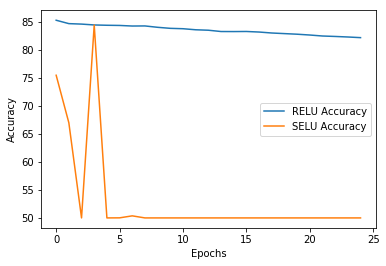

In [88]:
plt.plot(iterations,testacc_relu,label='RELU Accuracy')
plt.plot(iterations,testacc_selu,label='SELU Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [89]:
batches = range(len(trainloss_relu))

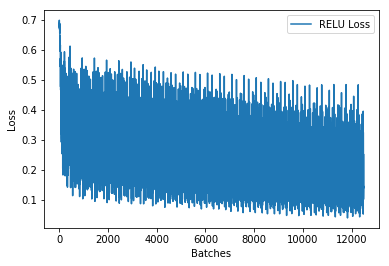

In [92]:
plt.plot(batches,trainloss_relu,label='RELU Loss')
plt.ylabel('Loss')
plt.xlabel('Batches')
plt.legend()
plt.show()

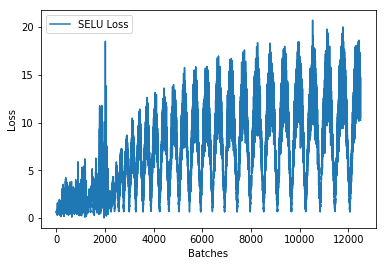

In [93]:
plt.plot(batches,trainloss_selu,label='SELU Loss')
plt.ylabel('Loss')
plt.xlabel('Batches')
plt.legend()
plt.show()